# Modeling for Sentence Selection

In [1]:
import numpy as np
import json
import pandas as pd
from pandas.io.json import json_normalize
import xapian
import string
import sys
import time
import glob
from pandas import DataFrame
import spacy
import import_ipynb
import ast
import csv
from Features_extraction import *

importing Jupyter notebook from Features_extraction.ipynb


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
Did not use initialization regex that was passed: .*token_embedder_tokens\._projection.*weight
Did not use initialization regex that was passed: .*token_embedder_tokens\._projection.*weight


In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc

### Reading Training File

In [242]:
trainset = pd.read_csv('train_set_with_features.csv')

In [295]:
interim_train_DF = trainset.groupby(['index', 'claim', 'label']).aggregate({'isGold': sum})
interim_train_DF.reset_index(inplace=True)

In [296]:
interimDF.head()

,index,claim,label,isGold
0,12,Carlos Santana disbanded Santana in 1965.,REFUTES,0
1,70,David Packouz was born in February of 1982.,SUPPORTS,1
2,97,Craig David is a pop music performer.,SUPPORTS,1
3,98,Craig David is a performer that does pop music.,NOT ENOUGH INFO,0
4,158,Wish Upon was released in France.,NOT ENOUGH INFO,0


In [297]:
df_without_NEI = interim_train_DF[~(interim_train_DF['label']=='NOT ENOUGH INFO')]

In [298]:
df_without_NEI.head()

,index,claim,label,isGold
0,12,Carlos Santana disbanded Santana in 1965.,REFUTES,0
1,70,David Packouz was born in February of 1982.,SUPPORTS,1
2,97,Craig David is a pop music performer.,SUPPORTS,1
5,369,The State of Palestine claims a territory in W...,REFUTES,0
6,422,John Krasinski is an astronaut.,REFUTES,1


In [299]:
df_withoutGold = without_NEI[~(without_NEI['isGold']==0)]

In [300]:
df_withoutGold.head(10)

,index,claim,label,isGold
1,70,David Packouz was born in February of 1982.,SUPPORTS,1
2,97,Craig David is a pop music performer.,SUPPORTS,1
6,422,John Krasinski is an astronaut.,REFUTES,1
10,493,Nuuk is a seat of government.,SUPPORTS,2
11,499,Paul Nicholls is a singer.,REFUTES,1
14,752,Tottenham Hotspur F.C. is a football club.,SUPPORTS,1
15,787,Shawn Carlson is only German.,REFUTES,1
17,833,TakePart is the digital division of Participan...,SUPPORTS,1
18,972,Stan Beeman is a fictional setting.,REFUTES,1
19,1035,Anushka Sharma is an actress.,SUPPORTS,1


In [301]:
train_to_use = set(df_withoutGold['index'].values)

In [302]:
df = trainset[trainset['index'].isin(train_to_use)]

In [303]:
sum(df['isGold'])/len(df)*100

21.99920350457985

### Reading Test File

In [ ]:
testset = pd.read_csv("test_set_with_features.csv")

## Modeling

In [ ]:
#have to change this after feature matrix
x = df[['percentage','weight','cosine_sim_tfidf','lcs','similarity']]
y = df['isGold']
y = y.astype('int')

In [401]:
#70% train 30% test 
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size =0.30,random_state =42,stratify=y)

In [403]:
#SMOTE
from imblearn.over_sampling import SMOTE
import numpy as np

sm = SMOTE(random_state=12)

x_train_res, y_train_res = sm.fit_sample(x_train, y_train)
x_test_res, y_test_res = sm.fit_sample(x_test, y_test)

In [ ]:
Counter(y_train_res)

#### n_estimators Tuning

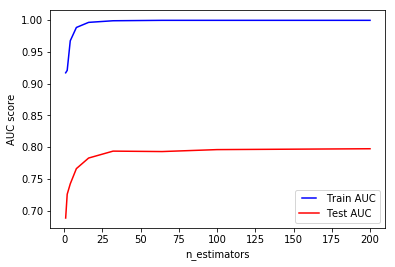

In [405]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(x_train_res, y_train_res)
    train_pred = rf.predict(x_train_res)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_res, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test_res)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_res, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt
%matplotlib inline
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()



#### Max Depth

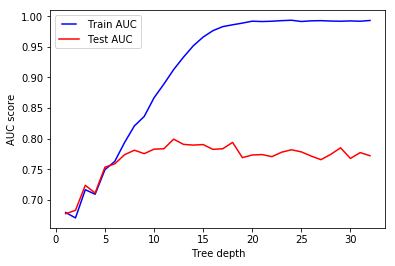

In [406]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(x_train_res, y_train_res)
    train_pred = rf.predict(x_train_res)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_res, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test_res)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_res, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
%matplotlib inline
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

###  Validation

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=25,
                              bootstrap = True,
                              max_features = 'auto', max_depth=18)
# Fit on training data
model.fit(x_train_res, y_train_res)

In [ ]:
y_pred = model.predict(x_test_res)

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_res, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

In [ ]:
print(classification_report(y_test_res, y_pred))
print(model.score(x_test_res,y_test_res))

In [415]:
#from testing set
x_features = test_set[['percentage','weight','cosine_sim_tfidf','lcs','similarity']]


### Testing with Random Forest

In [393]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=28,
                              bootstrap = True,
                              max_features = 'auto', max_depth=10)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=28, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [416]:
y_prediction = model.predict(x_features)

In [418]:
test_set["response"] = y_prediction

In [420]:
gold_MASK = y_prediction.astype(bool)

In [421]:
selected_sentences = test_set[gold_MASK]

In [426]:
selected_sentences.to_csv('testing_respone_is_one.csv')

In [550]:
sub = "testing_respone_is_one.csv"
testing_features_df = pd.read_csv((sub)) 

In [552]:
testing_features_df = testing_features_df.drop(['cosine_sim_tfidf','jaccard_sim','lcs','ngram','spaCy_similarity','text_topk','ir_lookup','percentage','weight'], axis=1)

In [553]:
testing_features_df = testing_features_df.drop(['Unnamed: 0'],axis=1)

In [554]:
testing_features_df.head(10)

,claim,claim_id,evidence_topk,response
0,Raven-Symoné is an Anglican.,110000,"['Raven-Symoné', '0']",1
1,Solanum contains plants with ornamental flowers.,16079,"['Solanum', '1']",1
2,Chadwick Boseman portrayed a film character.,226458,"['Chadwick_Boseman', '1']",1
3,Ghost is a film.,132649,"['Ghost_Dance_-LRB-film-RRB-', '0']",1
4,Ghost is a film.,132649,"['Nine_Girls_and_a_Ghost', '0']",1
5,Superhuman abilities may result from antelope ...,51262,"['Superhuman', '6']",1
6,Superhuman abilities may result from antelope ...,51262,"['Superhuman', '2']",1
7,Superhuman abilities may result from antelope ...,51262,"['Emma_Frost', '5']",1
8,Superhuman abilities may result from antelope ...,51262,"['X-Men', '5']",1
9,Superhuman abilities may result from antelope ...,51262,"['Thermoregulation_in_humans', '4']",1


In [555]:
def cleanItem(string):
    array = string.split(', ')
    return [str(array[0][2:-1]), int(array[1][1:-2])]

In [556]:
testing_features_df['evidence_topk']= testing_features_df['evidence_topk'].apply(lambda x:cleanItem(x))

In [545]:
testing_features_df.count()

claim            25292
claim_id         25292
evidence_topk    25292
response         25292
dtype: int64

In [557]:
testing_features_df.head()

,claim,claim_id,evidence_topk,response
0,Raven-Symoné is an Anglican.,110000,"[Raven-Symoné, 0]",1
1,Solanum contains plants with ornamental flowers.,16079,"[Solanum, 1]",1
2,Chadwick Boseman portrayed a film character.,226458,"[Chadwick_Boseman, 1]",1
3,Ghost is a film.,132649,"[Ghost_Dance_-LRB-film-RRB-, 0]",1
4,Ghost is a film.,132649,"[Nine_Girls_and_a_Ghost, 0]",1


In [560]:
#to merge all title_id and formating dataframe
model1_response_one= testing_features_df.groupby(['claim_id','claim']).evidence_topk.apply(list).reset_index()
model1_response_one.rename(columns={"evidence_topk": "evidence"}, inplace= True)
model1_response_one = model1_response_one.set_index('claim_id')
del model1_response_one.index.name
model1_response_one.head()

,claim,evidence
11,Carlos Santana formed Santana in 1966.,"[[Santana_-LRB-band-RRB-, 0], [Carlos_Santana_..."
24,The filming of Dilwale Dulhania Le Jayenge end...,"[[Dilwale_Dulhania_Le_Jayenge, 15], [List_of_r..."
69,David Packouz was born in 1982.,"[[David_Packouz, 0]]"
77,Nicholas Brody is also called Nick.,"[[Nicholas_Brody, 1]]"
83,Honeymoon is the third major-label record by L...,"[[Honeymoon_-LRB-Lana_Del_Rey_album-RRB-, 0], ..."


In [561]:
model1_response_one.head()

,claim,evidence
11,Carlos Santana formed Santana in 1966.,"[[Santana_-LRB-band-RRB-, 0], [Carlos_Santana_..."
24,The filming of Dilwale Dulhania Le Jayenge end...,"[[Dilwale_Dulhania_Le_Jayenge, 15], [List_of_r..."
69,David Packouz was born in 1982.,"[[David_Packouz, 0]]"
77,Nicholas Brody is also called Nick.,"[[Nicholas_Brody, 1]]"
83,Honeymoon is the third major-label record by L...,"[[Honeymoon_-LRB-Lana_Del_Rey_album-RRB-, 0], ..."


In [563]:
#rename to join later 
model1_response_one.rename(columns={"claim": "claim1"}, inplace= True)

In [564]:
# upload test_unlabelled to compare with model outputs
test_filepath = "test-unlabelled.json"
test_unlabelled_file = pd.read_json(open(test_filepath),orient='index') 
test_unlabelled_file.head()

,claim
110000,Raven-Symoné is an Anglican.
73397,Temple of the Dog celebrated the 37th annivers...
16079,Solanum contains plants with ornamental flowers.
114789,A Good Day to Die Hard is part of the Library ...
126871,The Icelandic Coast Guard is also known as Gae...


In [565]:
#comparing model and test_unlabelled
model_1= test_unlabelled_file.join(model1_response_one, how = 'left')
model_1= model1_rf.drop(['claim1'], axis=1)
model_1.count()

claim       14997
evidence     9645
dtype: int64

In [566]:
model_1.count()

claim       14997
evidence     9645
dtype: int64

In [567]:
#add label = Support to all
model_1['label']= 'SUPPORTS'

In [569]:
model_1.head()

,claim,evidence,label
110000,Raven-Symoné is an Anglican.,"[[Raven-Symoné, 0], [Raven-Symoné, 0], [Raven-...",SUPPORTS
73397,Temple of the Dog celebrated the 37th annivers...,NaN,SUPPORTS
16079,Solanum contains plants with ornamental flowers.,"[[Solanum, 1], [Solanum, 1], [Solanum, 1], [So...",SUPPORTS
114789,A Good Day to Die Hard is part of the Library ...,NaN,SUPPORTS
126871,The Icelandic Coast Guard is also known as Gae...,NaN,SUPPORTS


In [589]:
def cleanNAN(string):
    try:
        if np.isnan(string)==True:
            return []
    except:
        return string

In [590]:
#add label = NOT ENOUGH INFO
model_1['evidence'] = model_1['evidence'].apply(cleanNAN)

In [591]:
model_1.head()

,claim,evidence,label
110000,Raven-Symoné is an Anglican.,"[[Raven-Symoné, 0], [Raven-Symoné, 0], [Raven-...",SUPPORTS
73397,Temple of the Dog celebrated the 37th annivers...,[],SUPPORTS
16079,Solanum contains plants with ornamental flowers.,"[[Solanum, 1], [Solanum, 1], [Solanum, 1], [So...",SUPPORTS
114789,A Good Day to Die Hard is part of the Library ...,[],SUPPORTS
126871,The Icelandic Coast Guard is also known as Gae...,[],SUPPORTS


In [600]:
model_1['label']= model_1['evidence'].apply(lambda x: 'NOT ENOUGH INFO' if len(x)==0 else 'SUPPORTS')

In [601]:
model_1.head()

,claim,evidence,label
110000,Raven-Symoné is an Anglican.,"[[Raven-Symoné, 0], [Raven-Symoné, 0], [Raven-...",SUPPORTS
73397,Temple of the Dog celebrated the 37th annivers...,[],NOT ENOUGH INFO
16079,Solanum contains plants with ornamental flowers.,"[[Solanum, 1], [Solanum, 1], [Solanum, 1], [So...",SUPPORTS
114789,A Good Day to Die Hard is part of the Library ...,[],NOT ENOUGH INFO
126871,The Icelandic Coast Guard is also known as Gae...,[],NOT ENOUGH INFO


In [602]:
not_enough_data = model_1[model1_rf.label == "NOT ENOUGH INFO"] 
not_enough_data.count()

claim       5352
evidence    5352
label       5352
dtype: int64

In [603]:
# to json 
model_1.to_json('model_1_rf.json', orient='index') 

In [604]:
model_1.head()

,claim,evidence,label
110000,Raven-Symoné is an Anglican.,"[[Raven-Symoné, 0], [Raven-Symoné, 0], [Raven-...",SUPPORTS
73397,Temple of the Dog celebrated the 37th annivers...,[],NOT ENOUGH INFO
16079,Solanum contains plants with ornamental flowers.,"[[Solanum, 1], [Solanum, 1], [Solanum, 1], [So...",SUPPORTS
114789,A Good Day to Die Hard is part of the Library ...,[],NOT ENOUGH INFO
126871,The Icelandic Coast Guard is also known as Gae...,[],NOT ENOUGH INFO
